In [9]:
import pandas as pd

# Load your CSVs
land_cover_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Land_cover_percent_data.csv")
country_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")



# Round longitude and latitude to 1 decimal place
# land_cover_df["longitude"] = land_cover_df["longitude"].round(1)
# land_cover_df["latitude"] = land_cover_df["latitude"].round(1)

country_df["longitude"] = country_df["longitude"].round(1)
country_df["latitude"] = country_df["latitude"].round(1)

# Perform left join to keep all land cover rows
merged_df = pd.merge(
    land_cover_df,
    country_df,
    on=["longitude", "latitude"],
    how="left",   # left outer join
    validate="many_to_many"  # allow duplicates
)

# Save merged file
merged_df.to_csv("merged_landcover_rainfall.csv", index=False)

In [ ]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm  # for progress bar on large datasets

# Load your data
rain_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv")  # Sheet 1: rain points
country_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")  # Sheet 2: country centroids

# Prepare column for assigned country
rain_df["assigned_country"] = None

# Enable progress bar
tqdm.pandas()

# Function to find country for a given lat/lon point
def find_country(row):
    point = (row["latitude"], row["longitude"])
    
    for _, country in country_df.iterrows():
        center = (country["latitude"], country["longitude"])
        radius_km = country["centroid radius"]
        
        try:
            if geodesic(point, center).km <= radius_km:
                return country["country"]
        except:
            continue
    return None

# Apply with progress
rain_df["assigned_country"] = rain_df.progress_apply(find_country, axis=1)

# Save or return merged result
rain_df.to_csv("rainfall_with_country.csv", index=False)

 10%|▉         | 18882/194298 [06:00<56:03, 52.16it/s]  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the data
rain_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv")  # Sheet 1: rain points
country_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")  # Sheet 2: country centroids

# Prepare column for assigned country
rain_df["assigned_country"] = None

# Function to compute simple Euclidean distance in degrees
def euclidean_degrees(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2) ** 2 + (lon1 - lon2) ** 2)

# Enable progress bar
tqdm.pandas()

# Function to find country match
def find_country_deg(row):
    for _, country in country_df.iterrows():
        dist_deg = euclidean_degrees(
            row["latitude"], row["longitude"],
            country["latitude"], country["longitude"]
        )
        if dist_deg <= country["centroid radius"]:
            return country["country"]
    return None

# Apply matching
rain_df["assigned_country"] = rain_df.progress_apply(find_country_deg, axis=1)

# Save result
rain_df.to_csv("rainfall_with_country_deg.csv", index=False)

100%|██████████| 194298/194298 [06:09<00:00, 526.34it/s] 


In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Load the data
rain_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/Rainf_tavg_data.csv")  # Sheet 1: rain points
country_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")  # Sheet 2: country centroids

# Ensure proper float formatting (in case radius or coordinates are strings)
country_df["latitude"] = country_df["latitude"].astype(float)
country_df["longitude"] = country_df["longitude"].astype(float)
country_df["centroid radius"] = country_df["centroid radius"].astype(float)
rain_df["latitude"] = rain_df["latitude"].astype(float)
rain_df["longitude"] = rain_df["longitude"].astype(float)

# Add a new column to store the matched country name
rain_df["assigned_country"] = None

# Define simple Euclidean distance function in degrees
def euclidean_distance_deg(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

# Enable tqdm progress bar
tqdm.pandas()

def assign_country(row):
    candidates = []

    for _, country in country_df.iterrows():
        dist = euclidean_distance_deg(
            row["latitude"], row["longitude"],
            country["latitude"], country["longitude"]
        )
        if dist <= country["centroid radius"]:
            candidates.append((country["country"], dist))

    if candidates:
        # Choose the country with the smallest distance
        return min(candidates, key=lambda x: x[1])[0]
    
    return None  # No match found


# Apply assignment to each row with progress bar
rain_df["assigned_country"] = rain_df.progress_apply(assign_country, axis=1)

# Save the result
rain_df.to_csv("rainfall_with_country_assigned_3.csv", index=False)

100%|██████████| 194298/194298 [09:44<00:00, 332.59it/s]


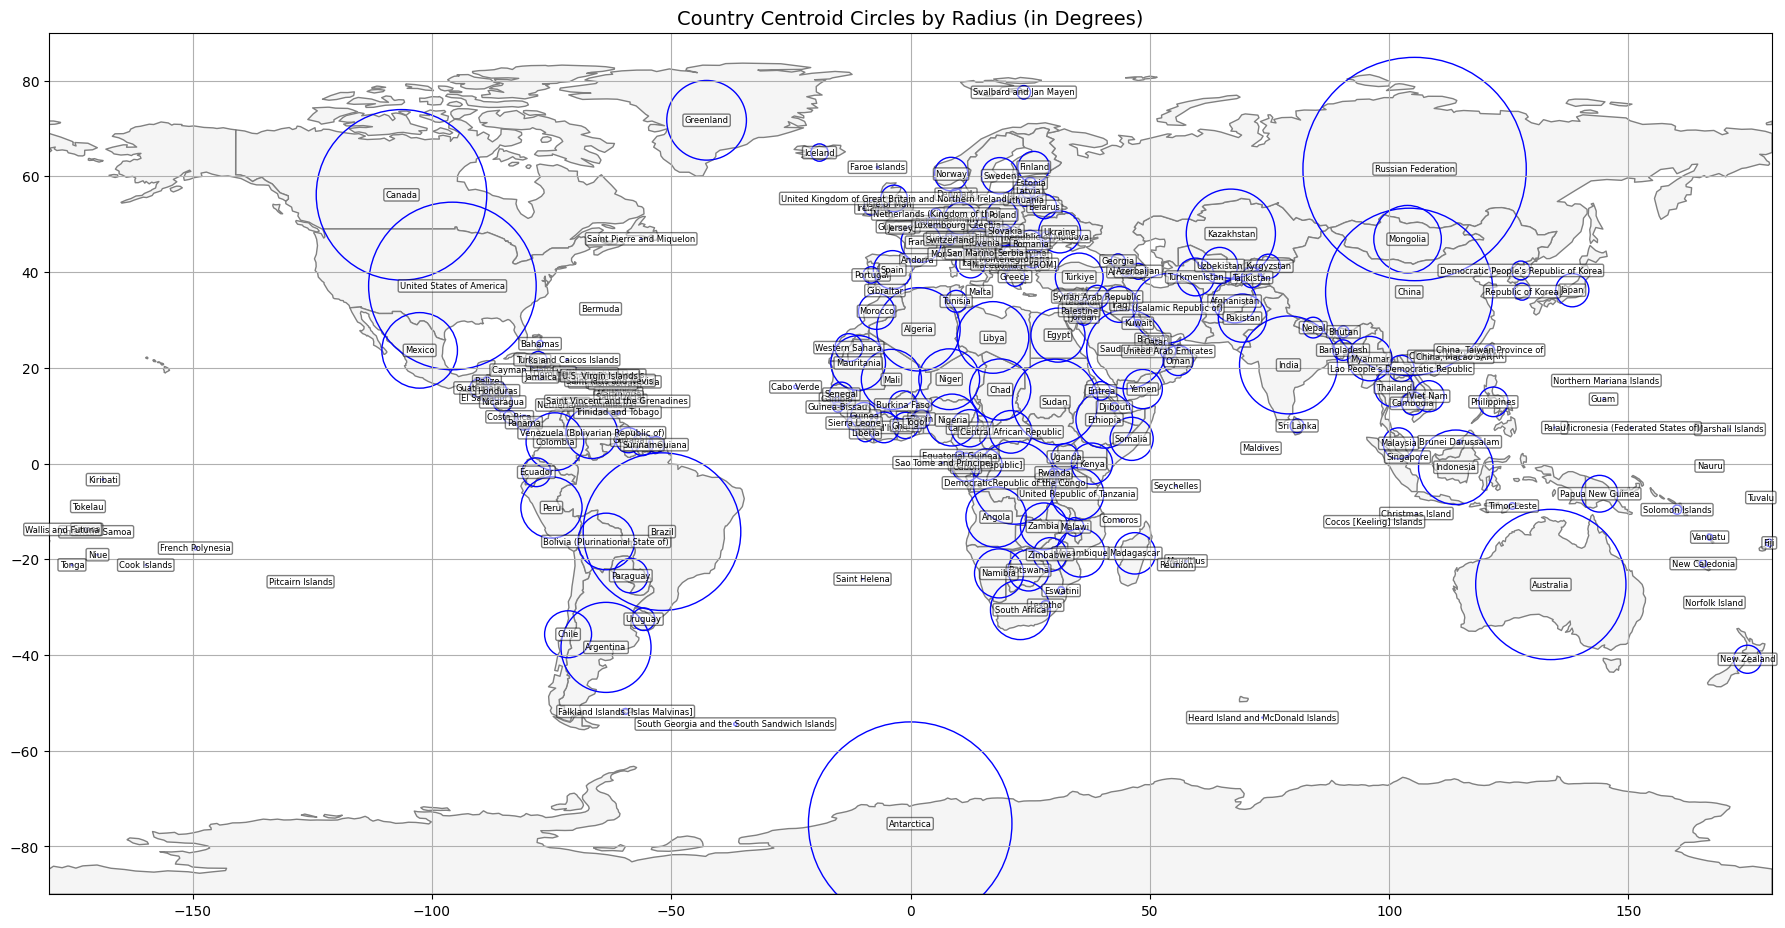

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from matplotlib.patches import Circle

# Load your centroid + radius CSV
centroids_df = pd.read_csv("/Users/suli/Documents/source/repo/MachineLearning/Final_Assignment/ML 2025 Coursework Dataset - A1/country_latitude_longitude_area_lookup.csv")

# Load Natural Earth shapefile (after extracting it)
world = gpd.read_file("./ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

# Create GeoDataFrame of centroids
centroids_df["geometry"] = centroids_df.apply(
    lambda row: Point(row["longitude"], row["latitude"]), axis=1
)
gdf = gpd.GeoDataFrame(centroids_df, geometry="geometry", crs="EPSG:4326")

# Plot world map
fig, ax = plt.subplots(figsize=(18, 10))
world.plot(ax=ax, color="whitesmoke", edgecolor="gray")

# Plot each centroid circle + label
for _, row in gdf.iterrows():
    if row["centroid radius"] > 0:
        circ = Circle(
            (row["longitude"], row["latitude"]),
            radius=row["centroid radius"],
            fill=False,
            edgecolor='blue',
            linewidth=1
        )
        ax.add_patch(circ)
        ax.text(
            row["longitude"],
            row["latitude"],
            row["country"],
            fontsize=6,
            ha="center",
            va="center",
            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.5)
        )

# Formatting
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)
ax.set_title("Country Centroid Circles by Radius (in Degrees)", fontsize=14)
ax.set_aspect('equal')
plt.grid(True)
plt.tight_layout()
plt.show()